In [609]:
from discover_lora_diffusion.models import LoraDiffusion
import diffusers
import torch
from tqdm import tqdm 

from common.utils import make_weight_vector, recover_lora, convert_to_multi, rand_merge_layerwise

lora_bundle = torch.load('/home/ubuntu/AutoLoRADiscovery/lora_bundle.pt')

_, weight_dict = make_weight_vector(lora_bundle[0])

lora_diffusion = LoraDiffusion(
    data_dim=1_365_504, 
    model_dim=512, 
    ff_mult=3, 
    chunks=1, 
    act=torch.nn.SiLU, 
    num_blocks=4, 
    layers_per_block=3
)

scheduler = diffusers.UnCLIPScheduler.from_config("kandinsky-community/kandinsky-2-2-prior", subfolder="scheduler")
state_dict = torch.load('/home/ubuntu/AutoLoRADiscovery/discover_lora_diffusion/diffusion_lora/checkpoint-50000')
lora_diffusion.load_state_dict(state_dict)
lora_diffusion = lora_diffusion.cuda().to(torch.float16)


In [610]:
import diffusers
from common.loras import patch_lora

pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe.safety_checker=None

lora_layers = [
        "attn2.to_q", 
        "attn2.to_k", 
        "attn2.to_v", 
        "attn2.to_out",
        # "proj_in",
        # "proj_out",
        # "norm",
        #  "ff", 
]
lora_layers_te = [
    "final_layer_norm",
    "7",
    "8",
    "9",
    "10",
    "11"
]

patch_lora(pipe.unet, rank=8, included_terms=lora_layers)
patch_lora(pipe.text_encoder, rank=8, included_terms=lora_layers_te)
pipe.scheduler = diffusers.EulerDiscreteScheduler.from_config(pipe.scheduler.config)


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


In [639]:
latents = torch.randn(1, 1_365_504).cuda().to(torch.float16)
scheduler.set_timesteps(200)

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        pred = lora_diffusion(latents, t=t.unsqueeze(0).cuda().half())
        latents = scheduler.step(pred, t, latents, return_dict=False)[0]

latents = latents * 0.0152

state_dict = recover_lora(latents, weight_dict)
state_dict = convert_to_multi(state_dict, idx=0)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 103.81it/s]


In [640]:
missing, unexpected = pipe.unet.load_state_dict(state_dict, strict=False)
missing, unexpected = pipe.text_encoder.load_state_dict(state_dict, strict=False)
pipe = pipe.to("cuda", torch.float16)

In [641]:
images = pipe("a photo of a sks person", height=640, width=640, num_inference_steps=30).images

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 17.83it/s]


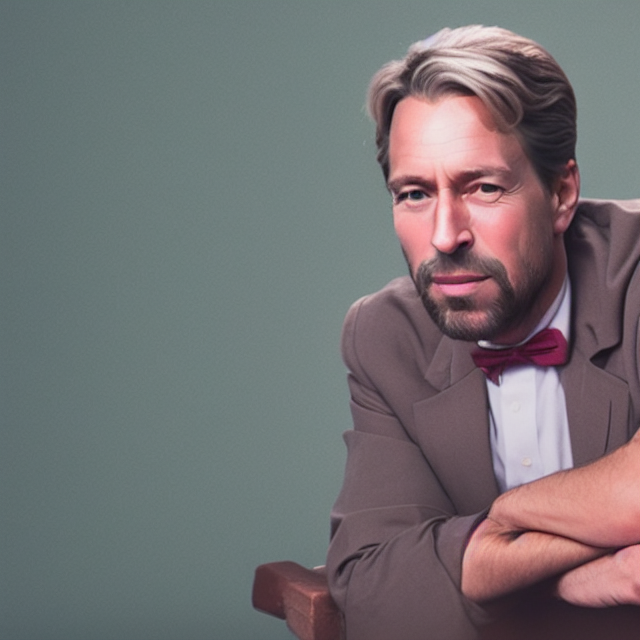

In [642]:
images[0]

In [643]:
images = pipe("a sks person as a chef", height=640, width=640, num_inference_steps=30).images

100%|██████████| 30/30 [00:01<00:00, 17.77it/s]


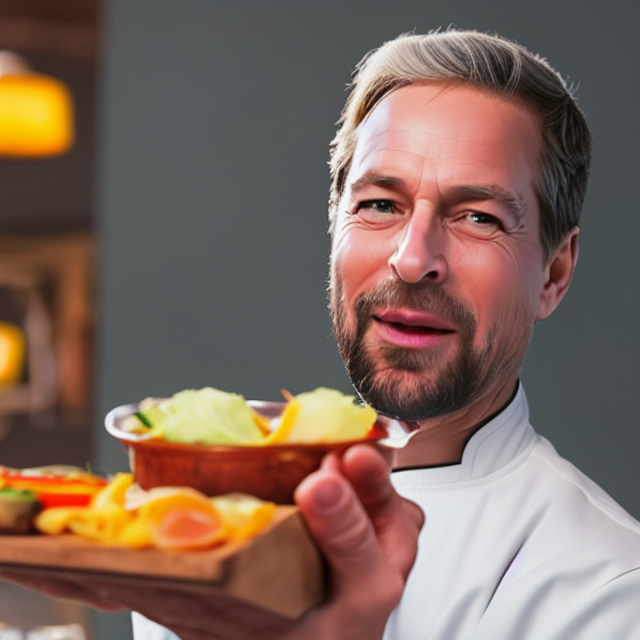

In [644]:
images[0]

In [478]:
images = pipe("a photo of a sks person", height=640, width=640, num_inference_steps=30).images

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 17.68it/s]


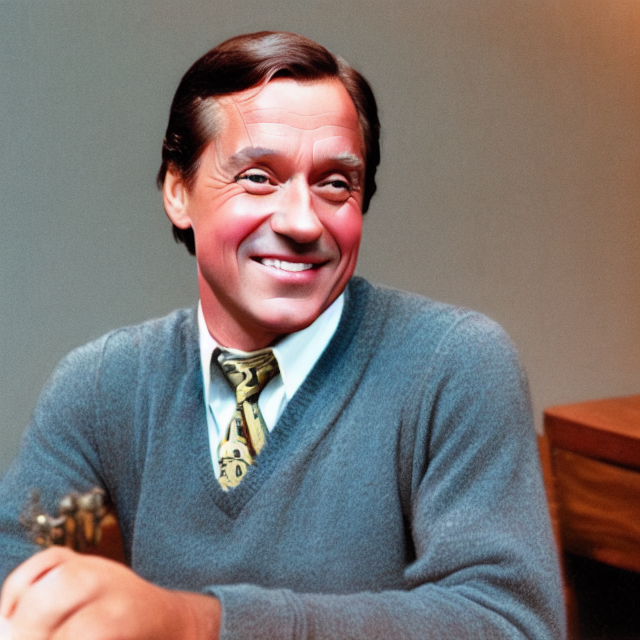

In [479]:
images[0]

In [480]:
images = pipe("a sks person as an astronaut", height=640, width=640, num_inference_steps=30).images

 10%|█         | 3/30 [00:00<00:01, 22.44it/s]

100%|██████████| 30/30 [00:01<00:00, 17.65it/s]


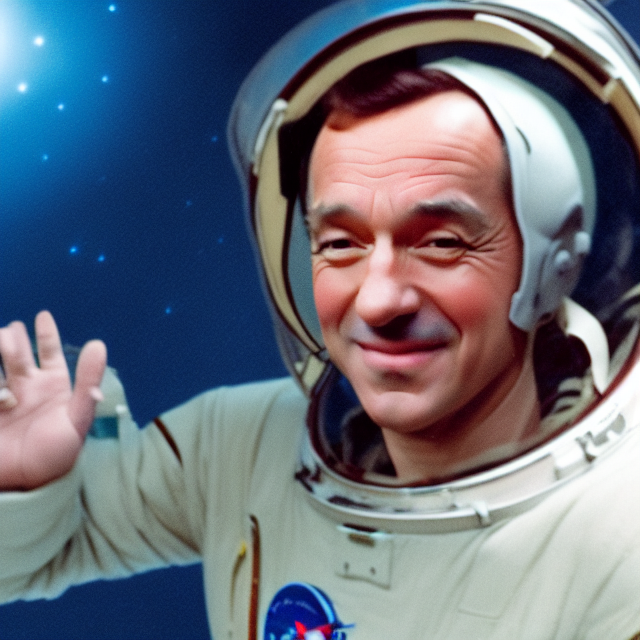

In [481]:
images[0]